In [1]:
# ============================================================
# PART 1: IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [2]:
# ============================================================
# PART 2: GLOBAL PLOT STYLING (AESTHETIC)
# ============================================================
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.figsize": (7, 4),
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


In [3]:
# ============================================================
# PART 3: LOAD DATASET + FAST SAMPLING
# ============================================================
df = pd.read_csv(
    r"C:\Users\Himanshu\Desktop\CLASS\sem 5\INT234\Project\NYPD_Arrest_Data__Year_to_Date_.csv",
    low_memory=False
)

# Use representative sample for faster execution
df = df.sample(n=25000, random_state=42)



In [4]:
# ============================================================
# PART 4: DATA CLEANING & FEATURE ENGINEERING
# ============================================================
df.drop(columns=["ARREST_KEY", "Location"], inplace=True, errors="ignore")

df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"], errors="coerce")

df["arrest_month"] = df["ARREST_DATE"].dt.month
df["arrest_weekday"] = df["ARREST_DATE"].dt.weekday
df["arrest_hour"] = df["ARREST_DATE"].dt.hour

df = df.dropna(subset=["LAW_CAT_CD"])


In [5]:
# ============================================================
# PART 5: FEATURE SELECTION
# ============================================================
features = [
    "AGE_GROUP",
    "PERP_SEX",
    "PERP_RACE",
    "ARREST_BORO",
    "arrest_month",
    "arrest_weekday",
    "arrest_hour"
]

X = df[features].copy()
y = df["LAW_CAT_CD"].copy()


In [6]:
# ============================================================
# PART 6: HANDLE MISSING VALUES
# ============================================================
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

X.loc[:, cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[cat_cols])
X.loc[:, num_cols] = SimpleImputer(strategy="median").fit_transform(X[num_cols])


In [7]:
# ============================================================
# PART 7: ENCODE CATEGORICAL VARIABLES
# ============================================================
le = LabelEncoder()

for col in cat_cols:
    X.loc[:, col] = le.fit_transform(X[col])

y = le.fit_transform(y)


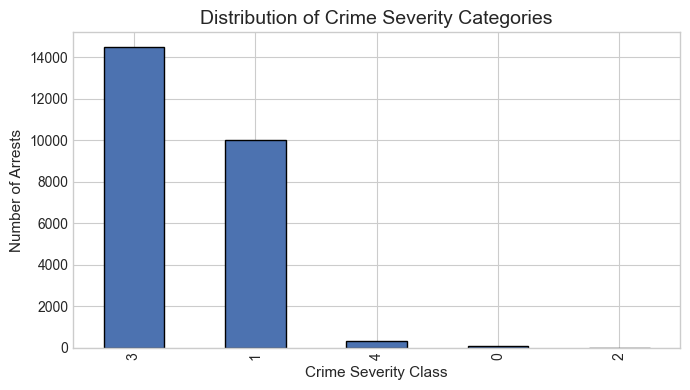

In [8]:
# ============================================================
# PART 8: EDA – CLASS DISTRIBUTION
# ============================================================
plt.figure()
pd.Series(y).value_counts().plot(
    kind="bar",
    color="#4C72B0",
    edgecolor="black"
)
plt.title("Distribution of Crime Severity Categories")
plt.xlabel("Crime Severity Class")
plt.ylabel("Number of Arrests")
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# PART 9: FEATURE SCALING
# ============================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


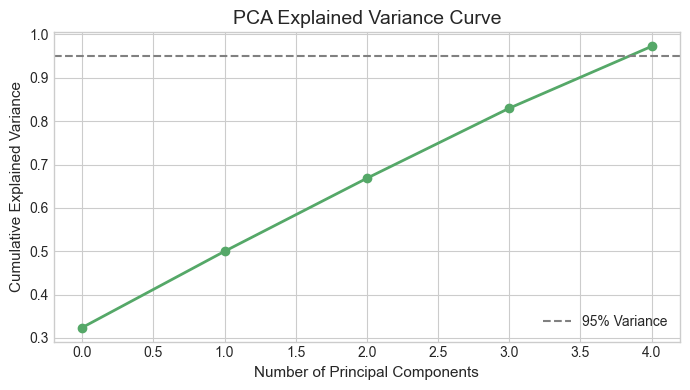

In [10]:
# ============================================================
# PART 10: PCA (FAST & SAFE)
# ============================================================
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.plot(
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
    linewidth=2,
    color="#55A868"
)
plt.axhline(y=0.95, linestyle="--", color="gray", label="95% Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# ============================================================
# PART 11: TRAIN–TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [12]:

# ============================================================
# PART 12: MODEL DEFINITIONS
# ============================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (Linear)": SVC(kernel="linear"),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(30,),
        max_iter=100,
        random_state=42
    )
}


In [13]:

# ============================================================
# PART 13: CONFUSION MATRIX FUNCTION (AESTHETIC)
# ============================================================
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()



Logistic Regression
Accuracy : 0.5869
Precision: 0.2222
Recall   : 0.2127
F1 Score : 0.1954


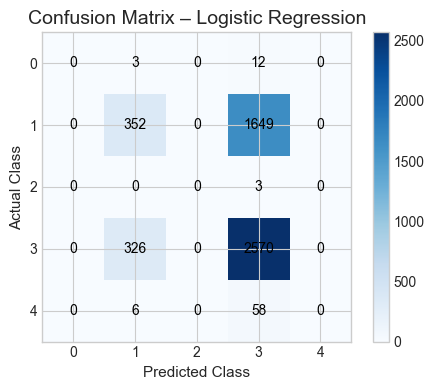


Decision Tree
Accuracy : 0.5700
Precision: 0.2835
Recall   : 0.2226
F1 Score : 0.2240


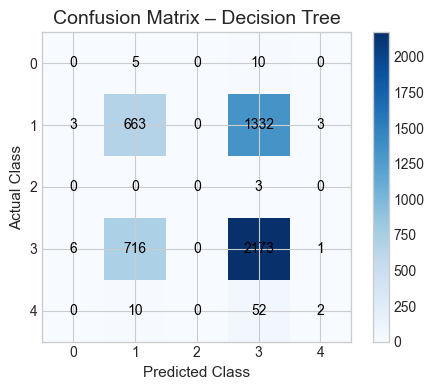


SVM (Linear)
Accuracy : 0.5816
Precision: 0.1163
Recall   : 0.2000
F1 Score : 0.1471


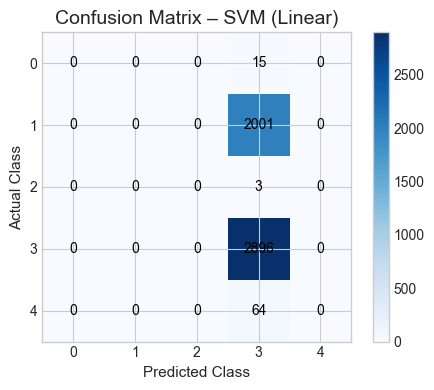


Neural Network (MLP)
Accuracy : 0.5873
Precision: 0.2237
Recall   : 0.2201
F1 Score : 0.2136


C:\Users\Himanshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


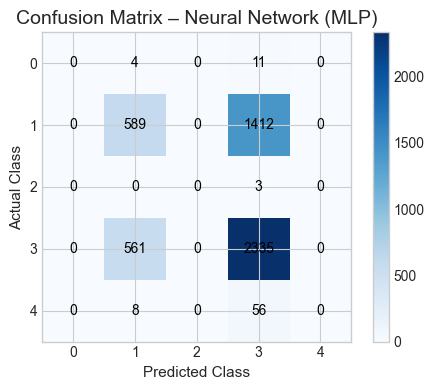

In [14]:
# ============================================================
# PART 14: MODEL TRAINING & EVALUATION
# ============================================================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    results.append([name, acc, prec, rec, f1])

    print(f"\n{name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    plot_confusion_matrix(confusion_matrix(y_test, y_pred), name)


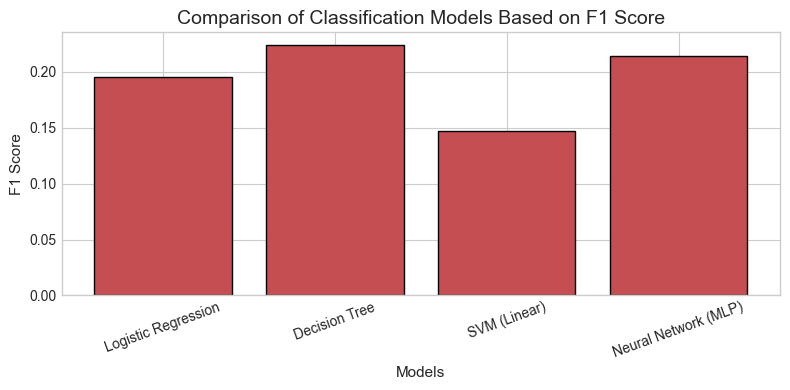


Model Performance Summary:
                  Model  Accuracy  Precision  Recall  F1 Score
0   Logistic Regression    0.5869     0.2222  0.2127    0.1954
1         Decision Tree    0.5700     0.2835  0.2226    0.2240
2          SVM (Linear)    0.5816     0.1163  0.2000    0.1471
3  Neural Network (MLP)    0.5873     0.2237  0.2201    0.2136


In [15]:

# ============================================================
# PART 15: MODEL COMPARISON VISUALIZATION
# ============================================================
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
)

plt.figure(figsize=(8, 4))
plt.bar(
    results_df["Model"],
    results_df["F1 Score"],
    color="#C44E52",
    edgecolor="black"
)
plt.title("Comparison of Classification Models Based on F1 Score")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print("\nModel Performance Summary:")
print(results_df.round(4))
